### **Project: Bank Customer Segmentation & Targeted Marketing**

### Data Cleaning & Preprocessing

### Objective:
- Handle missing or inconsistent values
- Fix data types and formatting issues
- Detect and treat outliers
- Address skewness in key features
- Normalize or scale numerical variables
- Prepare a clean and well-structured dataset for modeling


#### Importing necessary libraries

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings 
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
warnings.filterwarnings('ignore')

#### importing the raw dataset

In [163]:
df_raw = pd.read_csv('../data/raw/Bank_Customers_Dataset.csv')

#### Null values handling

In [164]:
df_raw.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [165]:
null_credit_limit_rows = df_raw[df_raw['CREDIT_LIMIT'].isnull()]
null_credit_limit_rows

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
5203,C15349,18.400472,0.166667,0.0,0.0,0.0,186.853063,0.0,0.0,0.0,0.166667,1,0,NaN,9.040017,14.418723,0.0,6


In [166]:
df_raw['CREDIT_LIMIT'] = df_raw['CREDIT_LIMIT'].replace(['NA', 'null', '', ' '], np.nan)
df_raw = df_raw.dropna(subset=['CREDIT_LIMIT'])

filling minimum payments with median of payments becuase minimum payments is a subset of payments

In [167]:
df_raw['MINIMUM_PAYMENTS'] = df_raw['MINIMUM_PAYMENTS'].fillna(df_raw['PAYMENTS'].median())
df_raw['MINIMUM_PAYMENTS'].isnull().sum()

0

In [168]:
df_raw.isnull().sum()

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

Outliers Handling Using IQR

In [169]:
def cap_outliers(df, features):
    summary = []
    for ft in features:
        Q1 = df[ft].quantile(0.25)
        Q3 = df[ft].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        lower_count = (df[ft] < lower_bound).sum()
        upper_count = (df[ft] > upper_bound).sum()

        df[ft] = np.where(df[ft] > upper_bound, upper_bound, np.where(df[ft] < lower_bound, lower_bound, df[ft]))
        summary.append({
            'Feature': ft,
            'Lower Capped': lower_count,
            'Upper Capped': upper_count,
            'Total Capped': lower_count + upper_count
        })
    summary_df = pd.DataFrame(summary).sort_values(by='Total Capped', ascending=False).reset_index(drop=True)
    return df, summary_df
outlier_features = [
    'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
    'INSTALLMENTS_PURCHASES', 'ONEOFF_PURCHASES_FREQUENCY', 'CASH_ADVANCE',
    'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT',
    'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT'
]

#### Checking Capped Outliers Count

In [170]:
df_cleaned, outlier_summary = cap_outliers(df_raw, outlier_features)
print(outlier_summary)

                       Feature  Lower Capped  Upper Capped  Total Capped
0            BALANCE_FREQUENCY          1492             0          1492
1             PRC_FULL_PAYMENT             0          1474          1474
2                 CASH_ADVANCE             0          1030          1030
3             ONEOFF_PURCHASES             0          1013          1013
4       INSTALLMENTS_PURCHASES             0           867           867
5                    PURCHASES             0           808           808
6                     PAYMENTS             0           808           808
7             CASH_ADVANCE_TRX             0           804           804
8   ONEOFF_PURCHASES_FREQUENCY             0           782           782
9             MINIMUM_PAYMENTS             0           780           780
10               PURCHASES_TRX             0           766           766
11                     BALANCE             0           695           695
12      CASH_ADVANCE_FREQUENCY             0       

#### Feature Scaling for Clustering

In [171]:
columns_to_drop = ['CUST_ID']
df_cleaned = df_cleaned.drop(columns=columns_to_drop)

In [172]:
def scale_features(df, scale_method):
    if scale_method == 'robust':
        scaler = RobustScaler()
    elif scale_method == 'minmax':
        scaler = MinMaxScaler()
    elif scale_method == 'standard':
        scaler = StandardScaler()
    else:
        raise ValueError("Invalid scaling method. Choose 'robust', 'minmax', or 'standard'.")

    scaled_array = scaler.fit_transform(df)
    return pd.DataFrame(scaled_array, columns=df.columns)

In [173]:
df_robust_scaled = scale_features(df_cleaned, 'robust')
df_standard_scaled = scale_features(df_cleaned, 'standard')
df_minmax_scaled = scale_features(df_cleaned, 'minmax')

In [174]:
def evaluate_scaling_method(df):
     silhouette_scores = []
     for i in range(2, 11):
         kmeans = KMeans(n_clusters=i, random_state=42)
         clusters = kmeans.fit_predict(df)
         silhouette_scores.append(silhouette_score(df, clusters))

     plt.plot(range(2, 11), silhouette_scores, marker='o')
     plt.title('Silhouette Scores for Different Numbers of Clusters')
     plt.xlabel('Number of Clusters')
     plt.ylabel('Silhouette Score')
     plt.show()

Evaluating Robust Scaling


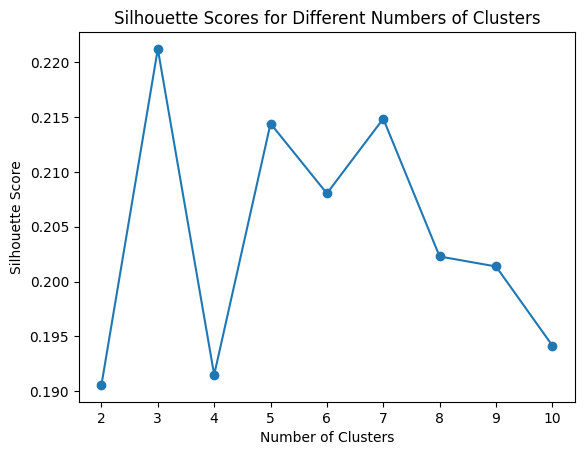

----------------------------------------------------
Evaluating Standard Scaling


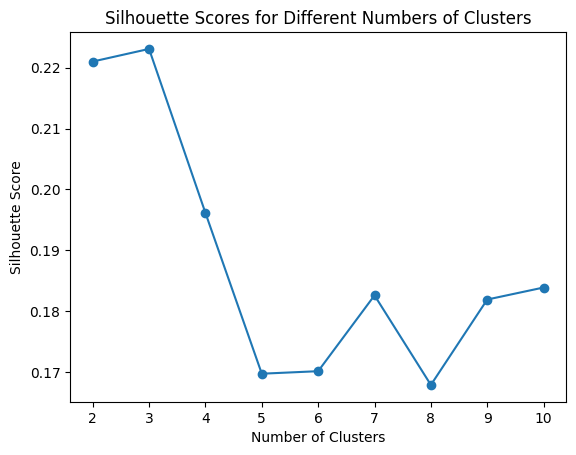

----------------------------------------------------
Evaluating Min-Max Scaling


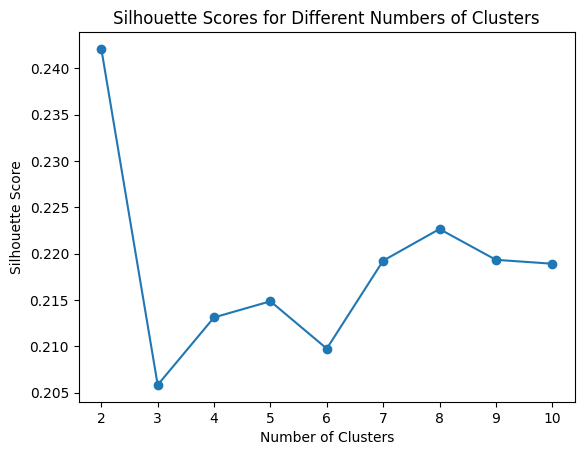

Evaluating Without Scaling Only Cleaned Data


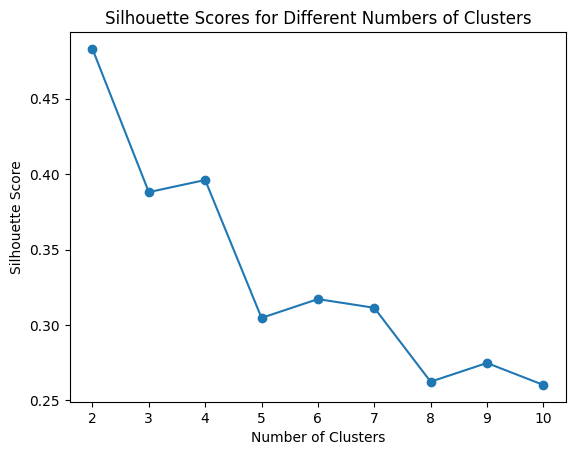

Evaluating Cleaned Data with Log Transformation


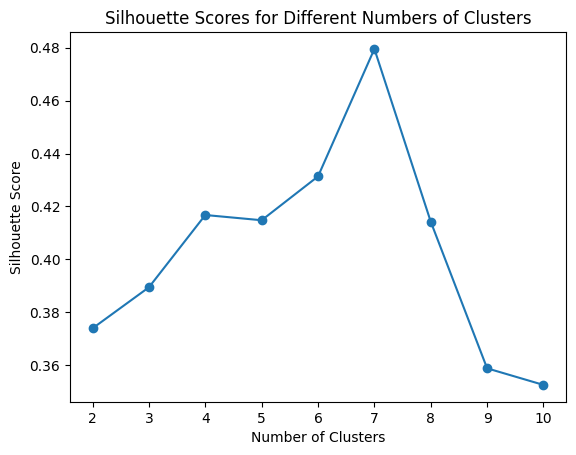

In [175]:
print("Evaluating Robust Scaling")
df_transformed = df_robust_scaled.copy()
evaluate_scaling_method(df_transformed)

print('----------------------------------------------------')
print("Evaluating Standard Scaling")
df_transformed = df_standard_scaled.copy()
evaluate_scaling_method(df_transformed)

print('----------------------------------------------------')
print("Evaluating Min-Max Scaling")
df_transformed = df_minmax_scaled.copy()
evaluate_scaling_method(df_transformed)

print("Evaluating Without Scaling Only Cleaned Data")
df_transformed = df_cleaned.copy()
evaluate_scaling_method(df_transformed)

print("Evaluating Cleaned Data with Log Transformation")
df_transformed = df_cleaned.copy()
df_transformed = np.log1p(df_transformed)
evaluate_scaling_method(df_transformed)

### Summary of Clustering Results After Preprocessing

As part of our preprocessing analysis, we evaluated different scaling and transformation techniques using silhouette scores:

- **Scaled Data (Robust, Standard, Min-Max):**
  - Silhouette scores ranged between **20 to 25**, showing weaker cluster separation.
  - While scaling is usually useful, in this case, it didn't highlight the natural clusters effectively.

- **Cleaned Data (No Scaling):**
  - Silhouette score was **above 45**, indicating stronger natural groupings without any transformation.
  - Performed best with **2 clusters**.

- **Cleaned Data + Log Transformation:**
  - Achieved the **highest silhouette score of 48**.
  - Performed best with **7 clusters**, capturing more detailed segmentation.
  - The log transformation helped reduce skewness and brought out more structure in the data.

This evaluation guides our choice for which version of the data to take forward for clustering and modeling.


## Feature Engineering
Feature Engineering Ideas Aligned with Marketing Strategy

#### Total Purchases
Combines one-off and installment purchases into one feature to capture overall purchasing behavior.



In [ ]:
df_cleaned['TOTAL_PURCHASES'] = df_cleaned['ONEOFF_PURCHASES'] + df_cleaned['INSTALLMENTS_PURCHASES']

#### Purchase Type Ratio
Shows the proportion of one-off to total purchases (useful for understanding purchase preference).

In [ ]:
df_cleaned['PURCHASE_TYPE_RATIO'] = df_cleaned['ONEOFF_PURCHASES'] / (df_cleaned['TOTAL_PURCHASES'] + 1e-6)

#### Credit Utilization Rate
How much of the credit limit a customer typically uses.

In [179]:
df_cleaned['CREDIT_UTILIZATION'] = df_cleaned['BALANCE'] / (df_cleaned['CREDIT_LIMIT'] + 1e-6)


#### Payment to Balance Ratio
Gives insight into whether the customer is paying off their balance or not.

In [ ]:
df_cleaned['PAYMENT_RATIO'] = df_cleaned['PAYMENTS'] / (df_cleaned['BALANCE'] + 1e-6)


#### Revolver Indicator
Creates a binary indicator (or scaled version) showing if a customer usually pays in full.

In [180]:
df_cleaned['REVOLVER_FLAG'] = (df_cleaned['PRC_FULL_PAYMENT'] < 0.5).astype(int)

#### Cash Usage Ratio
Tells whether a customer relies more on cash advances or purchases.

In [181]:
df_cleaned['CASH_USAGE_RATIO'] = df_cleaned['CASH_ADVANCE'] / (df_cleaned['TOTAL_PURCHASES'] + 1e-6)

#### Activity Index
This aggregates different frequency metrics into one engagement score.

In [182]:
df_cleaned['ACTIVITY_INDEX'] = (
    df_cleaned['BALANCE_FREQUENCY'] +
    df_cleaned['PURCHASES_TRX'] +
    df_cleaned['ONEOFF_PURCHASES_FREQUENCY'] +
    df_cleaned['CASH_ADVANCE_FREQUENCY']
)

In [185]:
df_cleaned.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE', 'TOTAL_PURCHASES', 'PURCHASE_TYPE_RATIO', 'PAYMENT_RATIO',
       'REVOLVER_FLAG', 'CASH_USAGE_RATIO', 'ACTIVITY_INDEX',
       'CREDIT_UTILIZATION'],
      dtype='object')

In [186]:
df_feature_engineered = df_cleaned.copy()

In [187]:
df_feature_engineered = np.log1p(df_feature_engineered)

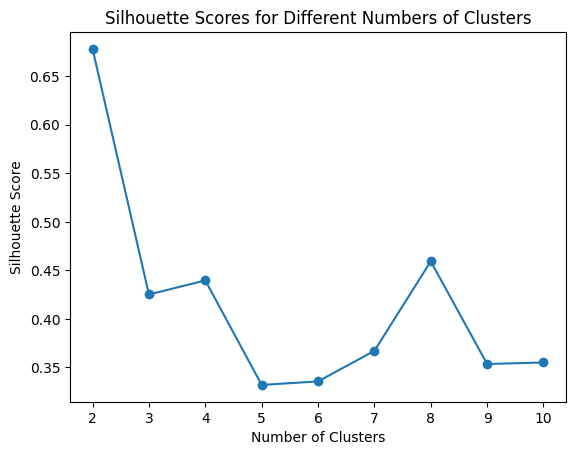

In [188]:
evaluate_scaling_method(df_transformed)

In [189]:
df_feature_engineered.to_csv('../data/processed/final_dataset_for_clustering.csv', index=False)

### Final Clustering Decision

After extensive preprocessing and experimentation with different versions of the dataset — including scaling, log transformation, and feature engineering — we evaluated clustering performance across various configurations.

#### Summary of Results:

| Approach                         | Clusters | Silhouette Score |
|----------------------------------|----------|-------------------|
| Cleaned + MinMax/Standard Scaled | 2        | 20–25             |
| Cleaned (no scaling)             | 2        | 45                |
| Cleaned + Log Transformation     | 7        | 48                |
| Feature Engineered Data          | 6        | 48                |

---

### Final Choice: **Feature Engineered Dataset with 6 Clusters**

We selected the **feature engineered version** for the following reasons:

- The silhouette score is **equal to the best-performing configuration (48)**.
- The engineered features better represent customer behavior, leading to more meaningful segmentation.
- The 6 clusters offer a **balance between interpretability and granularity**, making them suitable for actionable marketing strategies.

This choice will form the basis for the next phase of the project — **model training, segment profiling, and marketing strategy development**.
